# [Chapter 11] Exploring the online shopping data

## **[DSLC stages]**: EDA


In this document, you will find the PCS workflow and code for conducting an EDA of the online shopping data. Note that each section in this document corresponds to an interesting trend/finding. 

Recall that we examined and cleaned the shopping data in the file `01_cleaning.qmd`. In each subsequent file that uses the cleaned version of the data, and the cleaning/pre-processing "preparation" procedure is contained in the `R/prepareShoppingData.R` file, which is sourced below.



In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns

# define all of the objects we need by running the preparation script
%run functions/prepare_shopping_data.py

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100

In [2]:
# look at all variables defined in our space
%who

np	 pd	 preprocess_shopping_data	 px	 shopping_orig	 shopping_test	 shopping_test_preprocessed	 shopping_train	 shopping_train_preprocessed	 
shopping_train_preprocessed_nodummy	 shopping_val	 shopping_val_preprocessed	 sns	 


In [3]:
# let's also create a version of the data with the original month variable and no dummy variables:
shopping_train_preprocessed_month = preprocess_shopping_data(shopping_train, 
                                                             month_numeric=False, 
                                                             dummy=False)


## High-level summary of the data


Here are some histograms of the numeric variables (which we already saw in the cleaning doc, but this time it is for the preprocessed data).  

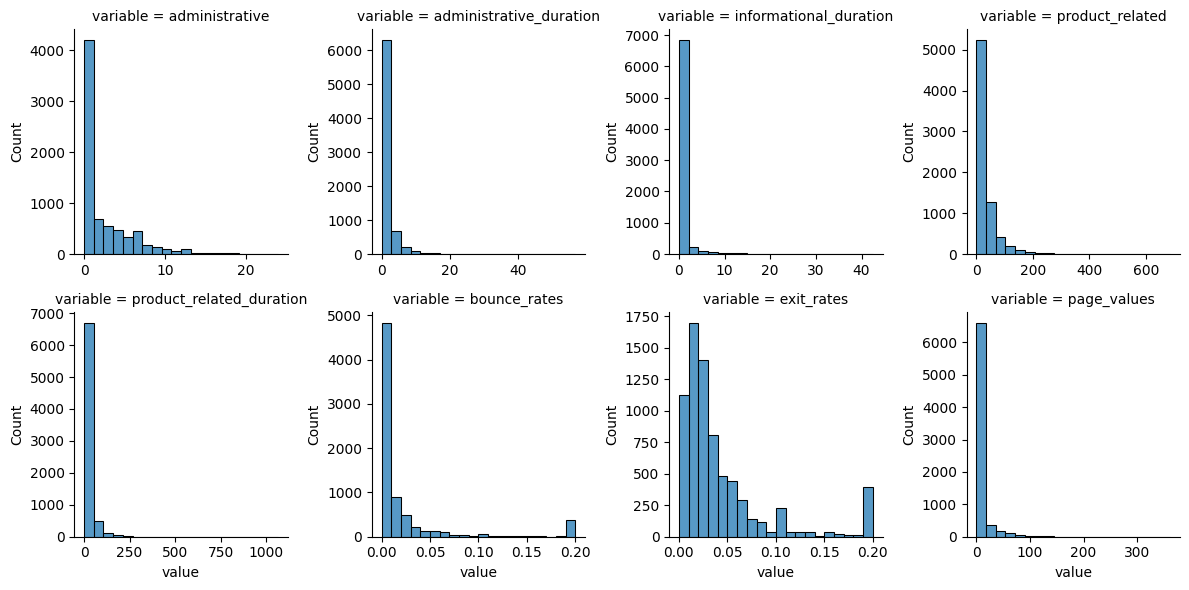

In [4]:
# create a version of the data with only variables that have at least 20 distinct values
continuous_variables = shopping_train_preprocessed.nunique() > 20
shopping_long = shopping_train_preprocessed.loc[:,continuous_variables] \
                                           .select_dtypes(include=['number']) \
                                           .melt()
g = sns.FacetGrid(shopping_long, col='variable', col_wrap=4, 
                  sharex=False, sharey=False)
g.map(sns.histplot, 'value', bins=20)


The following table shows a random sample of 15 sessions (this won't necessarily match the random sample that was in the book). 

First, let's look at one version of the clean/pre-processed data:

In [5]:
shopping_train_preprocessed.sample(15, random_state=234)

administrative  administrative_duration  informational  \
3469             1.0                 0.470000            0.0   
2846             1.0                 0.150000            0.0   
749              8.0                 2.166667            1.0   
6159             4.0                 2.900000            1.0   
3143             1.0                 0.050000            0.0   
2713             0.0                 0.000000            0.0   
7123             0.0                 0.000000            0.0   
4636             2.0                 1.116667            0.0   
1484             0.0                 0.000000            0.0   
5165             0.0                 0.000000            0.0   
6191             3.0                 0.750000            0.0   
3458             1.0                 0.133333            0.0   
6012             4.0                 1.825000            0.0   
7150             1.0                 0.470000            0.0   
155              1.0                 2.924667            0.0   

      informational_duration  product_related  product_related_duration  \
3469                0.000000              1.0                  0.000000   
2846                0.000000             32.0                  8.944722   
749                 0.300000             19.0                  4.966667   
6159                0.308333             11.0                  5.097917   
3143                0.000000            161.0                 62.724126   
2713                0.000000              1.0                  0.000000   
7123                0.000000              2.0                  0.366667   
4636                0.000000              8.0                  8.888333   
1484                0.000000             20.0                  5.555556   
5165                0.000000              8.0                  2.045833   
6191                0.000000             10.0                  9.655556   
3458                0.000000              6.0                  3.162500   
6012                0.000000             66.0                 20.520000   
7150                0.000000             35.0                 15.711465   
155                 0.000000             98.0                207.498333   

      bounce_rates  exit_rates  page_values  special_day  visitor_type  \
3469      0.000000    0.050000     0.000000          0.0             0   
2846      0.000000    0.000587     0.000000          0.0             1   
749       0.000000    0.016667    19.668185          0.0             1   
6159      0.000000    0.001709     0.000000          0.0             0   
3143      0.001667    0.012346     0.000000          0.0             1   
2713      0.200000    0.200000     0.000000          0.0             1   
7123      0.000000    0.100000     0.000000          0.0             1   
4636      0.000000    0.016667     0.000000          0.0             0   
1484      0.010000    0.040000     0.000000          0.0             1   
5165      0.000000    0.028571     0.000000          0.0             0   
6191      0.000000    0.022222     0.000000          0.0             0   
3458      0.000000    0.019048     0.000000          0.0             1   
6012      0.006280    0.028299    10.454377          1.0             1   
7150      0.017143    0.035442     8.435207          0.0             1   
155       0.002292    0.031103     0.000000          0.0             1   

      weekend  purchase  month_dec  month_feb  month_jul  month_june  \
3469        0      True          0          0          0           0   
2846        0     False          0          0          0           0   
749         1     False          0          0          0           0   
6159        1     False          0          0          0           0   
3143        0      True          0          0          0           0   
2713        0     False          0          0          0           0   
7123        0     False          1          0          0           0   
4636        0     F


### Correlation matrix

The heatmap below shows the correlation relationship between the continuous numeric variables.


In [6]:
px.imshow(shopping_train_preprocessed.select_dtypes(include=['number']).corr(),
          color_continuous_scale
          =["#F6AE2D", "white", "#18678B"], 
          color_continuous_midpoint=0,
          height = 1000)



What we can see is that there is a strong correlation between the `bounce_rates` and `exit_rates` variables, as well as between each page type and duration variable, such as between the `product_related` and `product_related_duration` variables, and the `informational` and `informational_duration` variables.



## Exploring the response (purchse)

Since our goal for this project is to predict which sessions will result in a purchase, let's take a closer look at the purchase response variable.

Around 84% of the training sessions *did not* result in a purchase.

In [7]:
shopping_train_preprocessed['purchase'].value_counts() / shopping_train_preprocessed.shape[0]

purchase
False    0.838714
True     0.161286
Name: count, dtype: float64


### Relationships between predictors and response (purchase)

Let's examine the relationship of several variables with the purchase response.


First, let's compare the numeric variables across sessions that resulted in a purchase and those that don't using boxplots. A version of the data that does not contain dummy variables will be helpful here:

In [8]:
# identify which numeric columns have at least 3 unique values 
to_melt = shopping_train_preprocessed_nodummy.select_dtypes(include='number').nunique() > 3
# include purchase in the list of variables to melt
to_melt['purchase'] = True
# get the index for just the True values
to_melt = to_melt[to_melt].index
# plot box plots
shopping_numeric_long = shopping_train_preprocessed_nodummy.loc[:,to_melt].melt(id_vars='purchase')
fig = px.box(shopping_numeric_long,
       x='purchase', y='value', 
       facet_col='variable', facet_col_wrap=3, 
       width=700, height=1000, 
       facet_row_spacing=0.05,
       facet_col_spacing=0.07)
fig.update_traces(width=0.5)
fig.update_yaxes(matches=None, showticklabels=True)


Since the distributions of almost all of the features are very skewed, the relationships thus might be clearer if we apply log-transformations to the predictor variables. In fact, this might also help our predictive performance later on (which is why we included the option to apply a logarithmic transformation as a pre-processing step in our pre-processing function).

The log-transformed feature distributions (by purchase response) are shown below:

In [9]:
shopping_numeric_long_log = shopping_numeric_long.copy()
shopping_numeric_long_log['value'] = np.log(shopping_numeric_long_log['value'] + 0.1)
fig = px.box(shopping_numeric_long_log,
       x='purchase', y='value', 
       facet_col='variable', facet_col_wrap=3, 
       width=700, height=1000, 
       facet_row_spacing=0.05,
       facet_col_spacing=0.07)
fig.update_traces(width=0.5)
fig.update_yaxes(matches=None, showticklabels=True)

It is now much clearer that there are some differences between sessions that did and did not have a purchase.


One particular trend is that *sessions that spend more time on product-related pages also tend to be more likely to end in a purchase* (the bottom-left boxplot). But this boxplot isn't a great way to convey this relevant piece of information to a general audience. Let's think about how to more clearly present this information in a more digestible manner.




### Explanatory figure: sessions that spend more time on product-related pages tend to be more likely to end in a purchase

Instead of a boxplot, perhaps we can present this information using a simple proportion, e.g., compare the proportion of sessions that made a purchase based on whether the session *spent at least one hour on product-related pages*.

One possible example is shown below:

In [10]:
# identify which sessions spend more than one hour browsing product-related pages
one_hour = shopping_train_preprocessed['product_related_duration'] > 60
# identify the proportion of sessions that ended with a purchase for sessions that did and did not spend more than one hour browsing product-related pages
prop_one_hour = shopping_train_preprocessed.groupby([one_hour])['purchase'].mean()
fig = px.bar(prop_one_hour)
fig.update_yaxes(title='Proportion of sessions making a purchase',
                 range=[0, 1],
                 tickformat='%',
                 tickvals=[0, 0.25, 0.5, 0.75, 1],
                 ticktext=['0%', '25%', '50%', '75%', '100%'])
fig.update_xaxes(labelalias=dict(false="< 1 hour spent on product-related pages", 
                                 true="> 1 hour spent on product-related pages"),
                 title=None)
# make the false bar gray and the true bar dark gray
fig.update_traces(marker_color=['lightgray', 'gray'], 
                  showlegend=False,
                  text=prop_one_hour.apply(lambda x: f'{x:.0%}'))
# update the background color and grid color
fig.update_layout(
    plot_bgcolor='white',
    yaxis_gridcolor='lightgrey',
)



As a brief stability test,  below we recreate this figure using a threshold of 90, instead of 60, minutes. Note that the results are virtually identical:


In [11]:
# identify which sessions spend more than one hour browsing product-related pages
one_hour = shopping_train_preprocessed['product_related_duration'] > 90
# identify the proportion of sessions that ended with a purchase for sessions that did and did not spend more than one hour browsing product-related pages
prop_one_hour = shopping_train_preprocessed.groupby([one_hour])['purchase'].mean()
fig = px.bar(prop_one_hour)
fig.update_yaxes(title='Proportion of sessions making a purchase',
                 range=[0, 1],
                 tickformat='%',
                 tickvals=[0, 0.25, 0.5, 0.75, 1],
                 ticktext=['0%', '25%', '50%', '75%', '100%'])
fig.update_xaxes(labelalias=dict(false="< 1 hour spent on product-related pages", 
                                 true="> 1 hour spent on product-related pages"),
                 title=None)
# make the false bar gray and the true bar dark gray
fig.update_traces(marker_color=['lightgray', 'gray'], 
                  showlegend=False,
                  text=prop_one_hour.apply(lambda x: f'{x:.0%}'))
# update the background color and grid color
fig.update_layout(
    plot_bgcolor='white',
    yaxis_gridcolor='lightgrey',
)



## In what months do the special days occur?

The special days feature is defined as "a numeric value between 0 and 1 indicating how closeness the site visiting time is to a "special day" in which the sessions are - hypothetically - more likely to be finalized with a transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentine’s day, `special_day` takes a nonzero value between February 2 and February 12, achieving the maximum value of 1 on February 8 (6 days before Valentine's day)."


Let's take a look and see when these special days actually occur. The following table shows that all of the special days occur in February and May (surprisingly not in November/December). Since the data dictionary (from the paper) definition of a special day specifically mentions Valentine's day (and Mother's day is in May), it is possible that this is a store that sells flowers or some other gift that is common for both Valentine's day and Mother's day...


In [12]:
# compute the number of non-zero special days each month
# note that special day may be a value in between 0 and 1
(shopping_train_preprocessed['special_day'] != 0).groupby(shopping_train_preprocessed_month['month']).sum()


month
Aug       0
Dec       0
Feb      46
Jul       0
June      0
Mar       0
May     695
Nov       0
Oct       0
Sep       0
Name: special_day, dtype: int64


We can also investigate whether the proportion of purchases increases on days with non-zero values of "special day". It seems that the opposite is actually true:

In [13]:
nonzero_special_day = shopping_train_preprocessed.special_day != 0
shopping_train_preprocessed.groupby(nonzero_special_day)['purchase'].mean()

special_day
False    0.172523
True     0.060729
Name: purchase, dtype: float64


The table above shows that over 17% of sessions that do not take place near special days end in a purchase, whereas only 6% of sessions near special days end in a purchase...



A next question that arises is whether the traffic and number of purchases actually increase during months with special days. Let's investigate




## Which months have the highest purchase rate


The bar chart below shows the number of sessions each month.

In [14]:
shopping_train_preprocessed_month['month'].value_counts()

month
May     1991
Nov     1812
Mar     1147
Dec     1021
Oct      336
Sep      263
Aug      261
Jul      259
June     177
Feb      105
Name: count, dtype: int64

In [15]:
month_order = ['Feb', 'Mar', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig = px.bar(shopping_train_preprocessed_month['month'].value_counts(),
             category_orders={'month': month_order})
fig.update_yaxes(title='Number of sessions')



Surprisingly, February actually has the *least* number of sessions. May, however, has the most sessions, followed by November, March and December

The bar chart below shows the *proportion* of the sessions each month that have a purchase. 

In [16]:
fig = px.bar(shopping_train_preprocessed_month.groupby('month')['purchase'].mean(),
       category_orders={'month': month_order})
fig.update_yaxes(title='Prop sessions with a purchase')


Again, February has substantially *fewer* sessions ending in a purchase, relative to the other months, and May does not seem like it has particularly high rate of purchases either. The later months in the year have (particularly November) have higher rates of purchases (and these proportions are actually surprisingly high--more than 20% of sessions having a purchase seems absurd. This data seems kind of fishy!).




## Do the proportion of sessions with purchases differ by browser, operating system, region, or type of traffic


Next, let's examine whether the proportion of sessions that make a purchase differs by browser, operating system, region, or type of traffic.

The bar charts below show that there isn't much difference in the rates of purchase across different regions and operating systems (except for "3"), but there are quite significant differences across browser and traffic type. 

In [17]:
fig = px.bar(shopping_train_preprocessed_month.groupby('browser')['purchase'].mean())
fig.update_yaxes(title='Prop sessions with a purchase')

In [18]:
fig = px.bar(shopping_train_preprocessed_month.groupby('operating_systems')['purchase'].mean())
fig.update_yaxes(title='Prop sessions with a purchase')

In [19]:
fig = px.bar(shopping_train_preprocessed_month.groupby('region')['purchase'].mean())
fig.update_yaxes(title='Prop sessions with a purchase')

In [20]:
fig = px.bar(shopping_train_preprocessed_month.groupby('traffic_type')['purchase'].mean())
fig.update_yaxes(title='Prop sessions with a purchase')